## Ticket Revenue Machine Learning Regression ##

## Data Import ##
Let's start by importing our packages and data - let's see what we're working with!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
raw_data = pd.read_csv('matinee_perf_data.csv')
raw_data.describe(include='all')

,perf_code,tickets_sold,perf_year,capacity_sold,inf_ASP,inf_revenue,days_on_sale,season,Matinee/Evening,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share
count,242,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242,242,242.000000,218.000000,218.000000,218.000000,218.000000
unique,242,NaN,NaN,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN
top,19OP0428AM,NaN,NaN,NaN,NaN,NaN,NaN,Fall,Evening,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,99,148,NaN,NaN,NaN,NaN,NaN
mean,NaN,1653.586777,2011.516529,0.669831,85.779587,144212.785785,332.665289,NaN,NaN,1.545455,0.428083,0.383860,0.571917,0.616140
std,NaN,554.741361,4.312692,0.203474,11.424783,51358.151051,129.692197,NaN,NaN,0.498962,0.152522,0.146358,0.152522,0.146358
min,NaN,171.000000,2005.000000,0.064000,47.400000,10929.010000,44.000000,NaN,NaN,1.000000,0.116200,0.113600,0.198200,0.234200
25%,NaN,1388.500000,2008.000000,0.611750,79.182500,121482.010000,243.000000,NaN,NaN,1.000000,0.302075,0.258300,0.460925,0.510250
50%,NaN,1709.500000,2011.000000,0.704000,85.440000,150920.625000,360.000000,NaN,NaN,2.000000,0.424850,0.379700,0.575150,0.620300
75%,NaN,2036.750000,2015.000000,0.791500,93.357500,179622.207500,437.000000,NaN,NaN,2.000000,0.539075,0.489750,0.697925,0.741700


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 14 columns):
perf_code          242 non-null object
tickets_sold       242 non-null int64
perf_year          242 non-null int64
capacity_sold      242 non-null float64
inf_ASP            242 non-null float64
inf_revenue        242 non-null float64
days_on_sale       242 non-null int64
season             242 non-null object
Matinee/Evening    242 non-null object
OA_grade           242 non-null int64
STB_Tkt_Share      218 non-null float64
STB_Rev_Share      218 non-null float64
SUB_Tkt_Share      218 non-null float64
Sub_Rev_Share      218 non-null float64
dtypes: float64(7), int64(4), object(3)
memory usage: 26.6+ KB


## Data Cleaning - Part 1 ##

There are a bunch of things to fix, so let's break them down one at a time:
    <ol>
    <li>We'll remove identifying data (perf_code) and look solely at the quantifiable variables for each performance</li>
    <li>All of these performances took place in the same venue, so "% of Capacity Sold" and "Tickets Sold" are essentially telling us the same info. We can also remove "Capacity Sold".</li>
    <li>The data ranges for "Tickets Sold" and "Days on Sale" don't match the business practices for this organization. They have never sold 171 seats in this venue, nor has a performance been on sale for 786 days. If we look at the distribution and sorted data below, it looks like the data from 2006 and 2007, when this data was first collected through a new ticketing system, is inaccurate.</li>
    <li>We also see some strong collinearity between "Days on Sale" and "Season", so let's be sure not to include both as regressors at the same time.
    </ol>

Time to scrub that data!

In [4]:
raw_data = raw_data[~raw_data.perf_code.str.contains('06OP')] #drop performances with seemingly inaccurate ticket-volume figures#
raw_data = raw_data.drop(['perf_code','capacity_sold'],axis=1) #Drop identifying information for each event and column that redundantly indicates ticket volume #

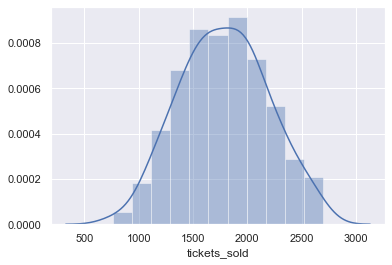

In [5]:
x = raw_data['tickets_sold']
sns.distplot(x)

In [6]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
raw_data.sort_values(by=['tickets_sold'])

,tickets_sold,perf_year,inf_ASP,inf_revenue,days_on_sale,season,Matinee/Evening,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share
226,763,2018,96.80,73857.90,190,Fall,Evening,2,0.5740,0.4694,0.4260,0.5306
227,798,2018,93.58,74681.19,192,Fall,Evening,2,0.6591,0.5747,0.3409,0.4253
167,954,2015,93.35,89060.40,358,Winter,Evening,2,0.3166,0.2312,0.6834,0.7688
187,999,2016,90.73,90637.68,442,Spring,Evening,2,0.3974,0.3067,0.6026,0.6933
152,1042,2014,85.28,88863.47,378,Winter,Evening,2,0.3417,0.2814,0.6583,0.7186
224,1048,2018,110.96,116285.98,185,Fall,Evening,2,0.5248,0.4508,0.4752,0.5492
58,1070,2008,69.84,74736.68,439,Spring,Evening,1,0.4430,0.4544,0.5570,0.5456
188,1073,2016,86.51,92829.62,444,Spring,Evening,2,0.4856,0.3837,0.5144,0.6163
45,1109,2006,73.44,81447.83,611,Fall,Evening,2,0.3183,0.2475,0.6817,0.7525
185,1130,2016,98.07,110820.21,437,Spring,Evening,2,0.3956,0.3072,0.6044,0.6928


## Check for Normal Distributions ##
We'll check for a normal distributions amongst our primary numerical variables.

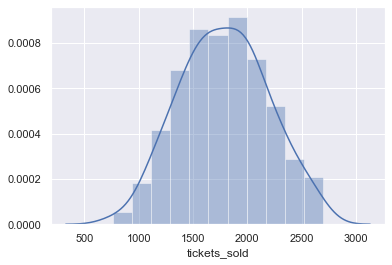

In [7]:
x = raw_data['tickets_sold']
sns.distplot(x)

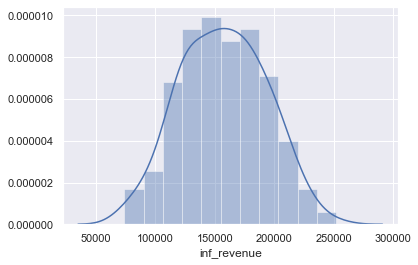

In [8]:
x = raw_data['inf_revenue']
sns.distplot(x)

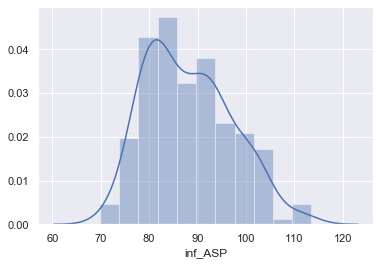

In [9]:
x = raw_data['inf_ASP']
sns.distplot(x)

In [10]:
raw_data.describe(include='all') #Double-check that there are no other missing values#

,tickets_sold,perf_year,inf_ASP,inf_revenue,days_on_sale,season,Matinee/Evening,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share
count,218.000000,218.000000,218.000000,218.000000,218.000000,218,218,218.000000,218.000000,218.000000,218.000000,218.000000
unique,NaN,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Fall,Evening,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,87,132,NaN,NaN,NaN,NaN,NaN
mean,1785.793578,2012.178899,88.191468,156865.112844,359.674312,NaN,NaN,1.495413,0.428083,0.383860,0.571917,0.616140
std,401.734670,4.022989,8.867892,35897.367417,105.323768,NaN,NaN,0.501130,0.152522,0.146358,0.152522,0.146358
min,763.000000,2006.000000,69.840000,73857.900000,185.000000,NaN,NaN,1.000000,0.116200,0.113600,0.198200,0.234200
25%,1489.500000,2008.000000,81.257500,128657.597500,259.750000,NaN,NaN,1.000000,0.302075,0.258300,0.460925,0.510250
50%,1782.500000,2012.000000,87.340000,156273.105000,373.000000,NaN,NaN,1.000000,0.424850,0.379700,0.575150,0.620300
75%,2060.750000,2016.000000,94.047500,182262.095000,439.000000,NaN,NaN,2.000000,0.539075,0.489750,0.697925,0.741700


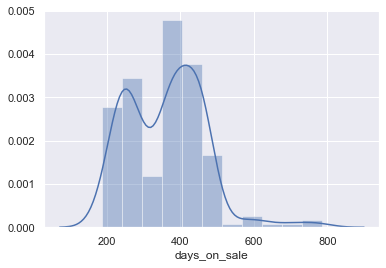

In [11]:
x = raw_data['days_on_sale']
sns.distplot(x)

In [12]:
pd.set_option("display.min_rows", None, "display.max_columns", None)
raw_data.sort_values(by=['days_on_sale'],ascending=False)

,tickets_sold,perf_year,inf_ASP,inf_revenue,days_on_sale,season,Matinee/Evening,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share
33,1386,2007,77.62,107587.46,786,Spring,Evening,1,0.3608,0.3084,0.6392,0.6916
34,1769,2007,81.34,143892.96,752,Spring,Evening,1,0.2510,0.2465,0.7490,0.7535
29,2663,2007,73.99,197022.62,712,Winter,Evening,1,0.5591,0.5279,0.4409,0.4721
27,2514,2007,77.05,193715.15,668,Winter,Evening,1,0.5438,0.5240,0.4562,0.4760
45,1109,2006,73.44,81447.83,611,Fall,Evening,2,0.3183,0.2475,0.6817,0.7525
43,2584,2006,74.17,191650.27,607,Fall,Evening,1,0.5712,0.5257,0.4288,0.4743
46,1631,2006,80.31,130998.31,577,Fall,Evening,2,0.1950,0.1638,0.8050,0.8362
39,2295,2006,78.46,180068.45,563,Fall,Evening,1,0.5181,0.4977,0.4819,0.5023
223,2441,2018,103.23,251996.35,482,Spring,Matinee,1,0.7349,0.7140,0.2651,0.2860
222,2029,2018,93.36,189425.52,480,Spring,Evening,1,0.7984,0.7658,0.2016,0.2342


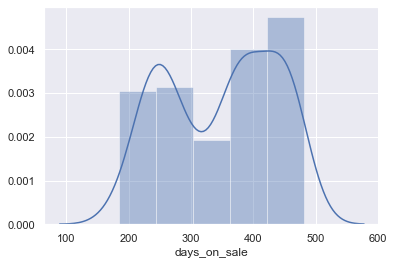

In [13]:
dropped_dos = raw_data[raw_data['days_on_sale'] > 500 ].index #Drop values that create the right-hand skew in the distribution curve above#
raw_data.drop(dropped_dos , inplace=True)
x = raw_data['days_on_sale'] #Re-run distribution curve#
sns.distplot(x)

## Data Cleaning - Part 2 ##

OK, just a few more steps with our data:
<ol>
    <li>Let's add the logarithmic values for both revenue and tickets sold. Both have a large range of values, so capturing the relationship of these variables may work better as a log-log model.</li>
    <li>Let's dummify the evening/matinee and season.</li>
    <li>We will create dummy variables for "Season" and "Matinee/Evening".</li>
    <li>We've adjusted revenue and and ASP for inflation, so we can remove "Perf Year" from our set of regressors.
        </ol>

In [14]:
raw_data['log_revenue'] = np.log(raw_data['inf_revenue'])
raw_data['log_tickets'] = np.log(raw_data['tickets_sold'])
raw_data.describe(include='all')

,tickets_sold,perf_year,inf_ASP,inf_revenue,days_on_sale,season,Matinee/Evening,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share,log_revenue,log_tickets
count,210.000000,210.000000,210.000000,210.000000,210.000000,210,210,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
unique,NaN,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Fall,Evening,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,83,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1777.866667,2012.395238,88.616000,157001.007381,348.252381,NaN,NaN,1.504762,0.428594,0.384000,0.571406,0.616000,11.936683,7.457128
std,392.332421,3.938641,8.741746,35672.252204,87.823976,NaN,NaN,0.501172,0.152908,0.146461,0.152908,0.146461,0.239287,0.234281
min,763.000000,2006.000000,69.840000,73857.900000,185.000000,NaN,NaN,1.000000,0.116200,0.113600,0.198200,0.234200,11.209898,6.637258
25%,1489.500000,2009.000000,81.802500,128657.597500,257.250000,NaN,NaN,1.000000,0.302075,0.258875,0.469050,0.513425,11.764909,7.306167
50%,1782.500000,2012.000000,88.305000,156273.105000,369.000000,NaN,NaN,2.000000,0.424850,0.379700,0.575150,0.620300,11.959360,7.485771
75%,2054.750000,2016.000000,94.207500,182221.035000,437.000000,NaN,NaN,2.000000,0.530950,0.486575,0.697925,0.741125,12.112976,7.627909


In [15]:
raw_data.drop(['perf_year'],axis=1)
data_with_days = pd.get_dummies(raw_data) #Dummify categorical variables#
data_with_days.describe()

,tickets_sold,perf_year,inf_ASP,inf_revenue,days_on_sale,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share,log_revenue,log_tickets,season_Fall,season_Spring,season_Winter,Matinee/Evening_Evening,Matinee/Evening_Matinee
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,1777.866667,2012.395238,88.616000,157001.007381,348.252381,1.504762,0.428594,0.384000,0.571406,0.616000,11.936683,7.457128,0.395238,0.319048,0.285714,0.590476,0.409524
std,392.332421,3.938641,8.741746,35672.252204,87.823976,0.501172,0.152908,0.146461,0.152908,0.146461,0.239287,0.234281,0.490070,0.467221,0.452833,0.492921,0.492921
min,763.000000,2006.000000,69.840000,73857.900000,185.000000,1.000000,0.116200,0.113600,0.198200,0.234200,11.209898,6.637258,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1489.500000,2009.000000,81.802500,128657.597500,257.250000,1.000000,0.302075,0.258875,0.469050,0.513425,11.764909,7.306167,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1782.500000,2012.000000,88.305000,156273.105000,369.000000,2.000000,0.424850,0.379700,0.575150,0.620300,11.959360,7.485771,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2054.750000,2016.000000,94.207500,182221.035000,437.000000,2.000000,0.530950,0.486575,0.697925,0.741125,12.112976,7.627909,1.000000,1.000000,1.000000,1.000000,1.000000
max,2696.000000,2019.000000,113.560000,251996.350000,482.000000,2.000000,0.801800,0.765800,0.883800,0.886400,12.437170,7.899524,1.000000,1.000000,1.000000,1.000000,1.000000


## Collinearity Analysis ##
In the collinearity analysis below, I realized that we're looking at a daisy-chain of factors: several of these variables accurately predict the number of tickets sold, but don't predict revenue. After running a handful of single-variable regressions and eliminating collinear variables one at a time, I found that the only variables that impact revenue without collinearity are, in order of significance: 
<ol>
    <li>the number of tickets sold;</li>
    <li>whether the performance is a matinee;</li>
    <li>whether the performance is a "top 10" title or not.</li>
    </ol>

In [16]:
x1 = data_with_days[['log_tickets','OA_grade','Matinee/Evening_Matinee']]
y = data_with_days['log_revenue']
#Calculate VIF to eliminate collinearity#
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = x1
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,9.900409,log_tickets
1,9.091445,OA_grade
2,1.734951,Matinee/Evening_Matinee


## Test/Train Split ##

We'll create a test/train split to begin creating our data model

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size = 0.2, random_state=42)
x_train.shape, y_train.shape

((168, 3), (168,))

In [18]:
#Create data model with training data#
x = sm.add_constant(x_train)
results = sm.OLS(y_train,x).fit()
results.summary()

C:\Users\SiddharthaMisra\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     513.8
Date:                Thu, 30 Apr 2020   Prob (F-statistic):           3.95e-83
Time:                        11:50:09   Log-Likelihood:                 201.61
No. Observations:                 168   AIC:                            -395.2
Df Residuals:                     164   BIC:                            -382.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       6.6711      0.262     25.448      0.000       6.154       7.189
log_tickets                 0.7161      0.034     21.263      0.000       0.650       0.783
OA_grade                   -0.0854      0.014     -5.957      0.000      -0.114      -0.057
Matinee/Evening_Matinee     0.1323      0.014      9.728      0.000       0.105       0.159
==============================================================================
Omnibus:                       23.544   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.917
Skew:                          -0.585   Prob(JB):                     1.19e-12
Kurtosis:                       5.545   Cond. No.                         357.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
#Create arrary of predicted values for test data using data model from training data#
predicted_values = reg.predict(x_test)
predicted_values

array([11.86717035, 12.23160029, 12.03972843, 11.69863512, 11.71556733,
       11.44630929, 11.74308516, 12.20347541, 12.26395395, 11.78624731,
       11.53707614, 11.97060136, 11.77598241, 11.86806716, 12.15301422,
       11.89907923, 11.54835353, 12.09093912, 11.91573809, 11.77820418,
       11.79116359, 11.81511564, 12.04572721, 12.25709829, 11.94731473,
       11.95721713, 12.21286262, 11.82703059, 11.91699477, 11.84298629,
       11.48059907, 12.27043733, 12.3392475 , 12.3245809 , 12.06560991,
       12.09513298, 11.67479045, 11.70415712, 12.27899153, 12.14367783,
       11.72047214, 12.16178956])

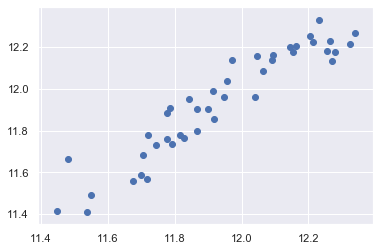

In [21]:
#Compare predicted values with data model to actual values from test data#
plt.scatter(predicted_values,y_test)
plt.show()

## Feature Scaling ##

I've never tried feature scaling with a combination of numerical and categorical variables, so I'm curious to see if the coefficients change after scaling our variables.

In [22]:
scaler = StandardScaler()
scaler.fit(x1)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
x_scaled = scaler.transform(x1)
x_scaled

array([[ 1.13427926, -1.0095696 , -0.83279553],
       [ 1.64116887, -1.0095696 ,  1.20077494],
       [ 1.29603464, -1.0095696 , -0.83279553],
       [ 1.89282595, -1.0095696 ,  1.20077494],
       [-0.1794972 , -1.0095696 , -0.83279553],
       [-0.10797315, -1.0095696 , -0.83279553],
       [ 0.79117919, -1.0095696 ,  1.20077494],
       [ 0.50902   , -1.0095696 ,  1.20077494],
       [ 0.72288615, -1.0095696 , -0.83279553],
       [ 1.22984142, -1.0095696 ,  1.20077494],
       [ 0.96616746, -1.0095696 , -0.83279553],
       [ 1.50782666, -1.0095696 ,  1.20077494],
       [-0.36910183,  0.99052111, -0.83279553],
       [-0.51981956,  0.99052111, -0.83279553],
       [ 0.55699632,  0.99052111,  1.20077494],
       [ 1.07705276,  0.99052111,  1.20077494],
       [-0.05260264, -1.0095696 , -0.83279553],
       [ 0.34129911,  0.99052111, -0.83279553],
       [ 0.7061648 ,  0.99052111,  1.20077494],
       [-0.24438426,  0.99052111, -0.83279553],
       [ 0.42709919,  0.99052111, -0.832

In [24]:
x = sm.add_constant(x_scaled)
results = sm.OLS(y,x_scaled).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            log_revenue   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.014
Method:                 Least Squares   F-statistic:                            0.02486
Date:                Thu, 30 Apr 2020   Prob (F-statistic):                       0.995
Time:                        11:50:10   Log-Likelihood:                         -818.70
No. Observations:                 210   AIC:                                      1643.
Df Residuals:                     207   BIC:                                      1653.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1646      1.161      0.142      0.887      -2.124       2.454
x2            -0.0426      1.030     -0.041      0.967      -2.072       1.987
x3             0.0688      0.992      0.069      0.945      -1.887       2.024
==============================================================================
Omnibus:                       16.321   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.570
Skew:                          -0.403   Prob(JB):                     3.79e-07
Kurtosis:                       4.652   Cond. No.                         2.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

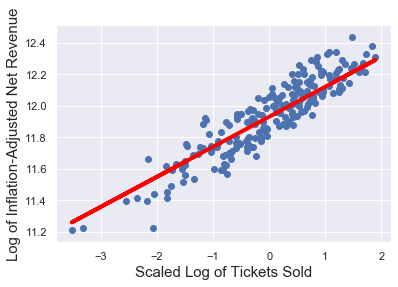

In [25]:
x1 = x_scaled[:,0]
plt.scatter(x1,y,cmap ='rainbow')
plt.xlabel('Scaled Log of Tickets Sold', fontsize = 15)
plt.ylabel('Log of Inflation-Adjusted Net Revenue', fontsize = 15)
yhat = x1 * (.1646-.0426+.0688)+11.93
fig = plt.plot(x1,yhat, lw=4, c='red', label ='Regression')
plt.show()

## Continued Collinearity Analysis ##

As mentioned before, we have a chain effect: several of these variables predict number of tickets sold which, in turn, is the primary predictor of revenue. Let's see if we can create a second data model that examines these underlying variables and their impact on ticket volume, using several of the same steps we performed above.

In [28]:
x2 = data_with_days[['Matinee/Evening_Matinee','SUB_Tkt_Share','OA_grade','season_Winter']]
y = data_with_days['tickets_sold']
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = x2
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,1.709122,Matinee/Evening_Matinee
1,10.279389,SUB_Tkt_Share
2,10.757762,OA_grade
3,1.610336,season_Winter


In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x2, y, test_size = 0.2, random_state=42)
x_train.shape, y_train.shape

((168, 4), (168,))

In [30]:
x = sm.add_constant(x_train)
results = sm.OLS(y_train,x).fit()
results.summary()

C:\Users\SiddharthaMisra\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           tickets_sold   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     45.83
Date:                Thu, 30 Apr 2020   Prob (F-statistic):           9.34e-26
Time:                        11:50:11   Log-Likelihood:                -1176.9
No. Observations:                 168   AIC:                             2364.
Df Residuals:                     163   BIC:                             2379.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2141.2349     89.116     24.028      0.000    1965.265    2317.205
Matinee/Evening_Matinee   330.8286     43.406      7.622      0.000     245.117     416.540
SUB_Tkt_Share             456.9177    148.813      3.070      0.003     163.067     750.768
OA_grade                 -516.3268     47.739    -10.816      0.000    -610.594    -422.059
season_Winter              75.3714     48.615      1.550      0.123     -20.624     171.367
==============================================================================
Omnibus:                        0.622   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.733   Jarque-Bera (JB):                0.321
Skew:                           0.062   Prob(JB):                        0.852
Kurtosis:                       3.175   Cond. No.                         15.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
reg = LinearRegression()
reg.fit(x_train,y_train)
reg.score(x_train,y_train)

0.5293419669077499

In [32]:
predicted_values = reg.predict(x_test)
predicted_values

array([1963.57552053, 2132.10696793, 1775.24444609, 1305.17296215,
       1539.57172832, 1383.9199414 , 1482.97969288, 2108.66709132,
       2266.80629789, 1639.31143842, 1381.79805588, 1755.22106171,
       1638.03206894, 1853.96097081, 1782.09821119, 1498.08360362,
       1408.07082207, 1880.9094396 , 1817.77309112, 1452.41190056,
       1463.12940165, 1444.41584129, 1699.5331877 , 2227.8312204 ,
       1883.43216071, 1707.89478111, 2263.69925772, 1858.98706521,
       1996.38220944, 1827.50543755, 1325.70862988, 2230.07011699,
       2184.65250031, 2245.19409197, 1834.76075464, 1672.20951086,
       1754.5356852 , 1437.88191857, 2219.65239405, 2203.84304257,
       1393.2209977 , 2157.28313171])

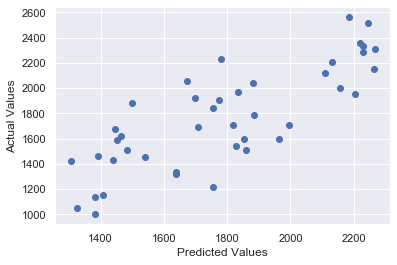

In [33]:
plt.scatter(predicted_values,y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

## Conclusion ##

Through these 2 data models, we find 3 variables that impact the revenue for a given performance, the most significant of which is ticket volume. In addition, there are 4 additional variables that less reliability predict audience demand for a given performance.

My recommendations would be to focus on ticket volume, first and foremost, to maximize revenue; and perhaps to divert advertising and marketing resources away from "top 10" titles and matinee performances, as those have an inherently greater demand. In addition, there is evidence that improving subscription sales will result in larger overall ticket volume and, in turn, higher revenue.